In [1]:
import numpy as np
import sys,os
module_root = '..'
sys.path.append(module_root)
from settings import raw_folder, train_folder, intermediate_folder
import glob
import seaborn as sns
import SimpleITK as sitk
import pandas as pd
from ipywidgets import interact, widgets

In [2]:
folders_list = sorted(os.listdir(os.path.join(raw_folder, 'second attempt')))
type_dropdown = widgets.Dropdown(
    options=folders_list,
    value=folders_list[-1],
    description='source: ',
)
display(type_dropdown)

Dropdown(description='source: ', index=1, options=('test', 'train'), value='train')

In [3]:
folders_list = sorted(os.listdir(os.path.join(raw_folder, 'second attempt', type_dropdown.value)))
folder_dropdown = widgets.Dropdown(
    options=folders_list,
    value=folders_list[-1],
    description='folder: ',
)
display(folder_dropdown)

Dropdown(description='folder: ', index=3, options=('1039-2088DA037-3', '1039-2088DA037-4', '1039-2088DA039-3', '1039-2088DA039-4'), value='1039-2088DA039-4')

In [4]:
annotation_folder = os.path.join(raw_folder,'second attempt', type_dropdown.value, folder_dropdown.value)
print(annotation_folder)
print(os.path.isdir(annotation_folder))
tifs = sorted(glob.glob( annotation_folder + '/*.tif'))
print('no of tifs: {}'.format(len(tifs)))

/media/deepinfer/mehrtash/qanat/raw/second attempt/train/1039-2088DA037-3
True
no of tifs: 1


In [5]:
image_index = 0
tif_path = tifs[image_index]
image = sitk.ReadImage(tif_path)
nda = sitk.GetArrayFromImage(image)

In [6]:
labels = sorted(glob.glob(raw_folder + '/' + os.path.basename(tif_path).split('.')[0] + '_label_*.nrrd'))
print('no of labels: {}'.format(len(labels)))

no of labels: 2


In [7]:
label_index = 0
label_path = labels[label_index]
label = sitk.ReadImage(label_path)
label_nda = sitk.GetArrayFromImage(label).squeeze()
label_mask = np.ma.masked_where(label_nda== 0, label_nda)

In [8]:
print(label_path)
roi_path = label_path.replace('.nrrd', '_roi.acsv')

/media/deepinfer/mehrtash/qanat/raw/1039-2088DA037-3_label_1.nrrd


In [9]:
roi = np.zeros((2,2))
i = 0
with open(roi_path) as f:
    for line in f.readlines():
        if line.startswith('point'):
            p = line.split('|')
            roi[i,0] = -float(p[1])
            roi[i,1] = -float(p[2])
            i += 1

In [10]:
center = list(roi[0])
center = np.asarray(image.TransformPhysicalPointToIndex(center))
spacing = image.GetSpacing()
length = np.abs(roi[1]/spacing).astype(np.int)
start = center - length
end = center + length
print(start,end)

[6581 5227] [8585 7231]


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
from matplotlib import colors
cmap = colors.ListedColormap(['orange', 'red'])

In [13]:
nda.shape
#nda[start[1]:end[1], start[0]:end[0]].shape

(7796, 18625)

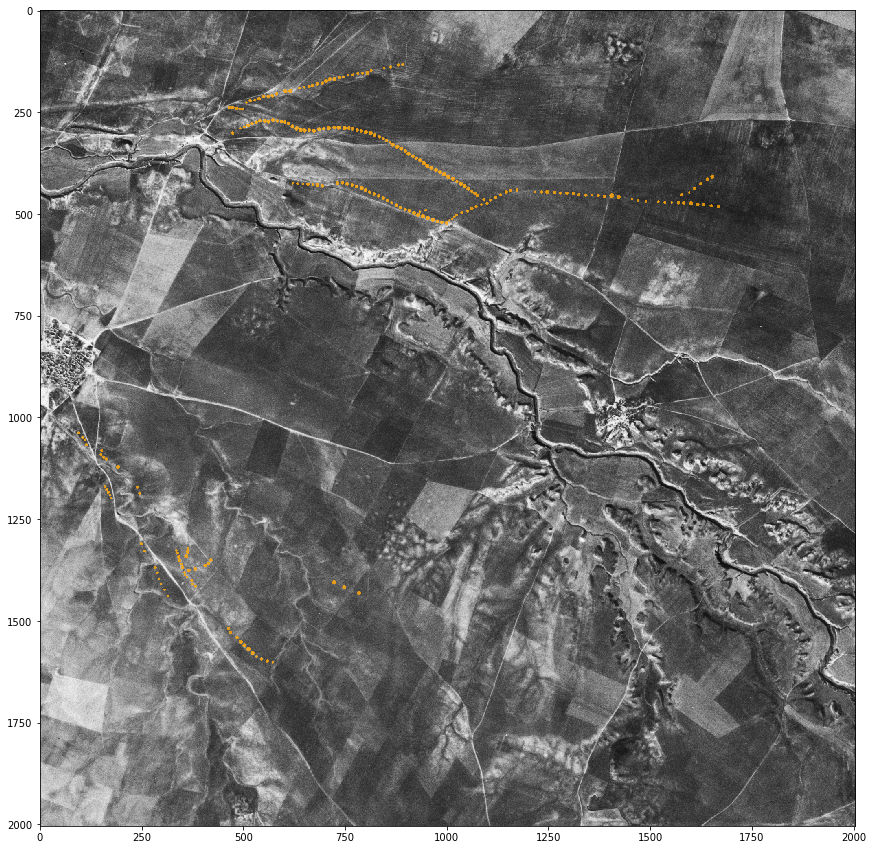

In [14]:
#
plt.figure(figsize=(15,15))
plt.imshow(nda[start[1]:end[1], start[0]:end[0]], cmap=plt.cm.gray)
plt.imshow(label_mask[start[1]:end[1], start[0]:end[0]], alpha=0.8, cmap=cmap)

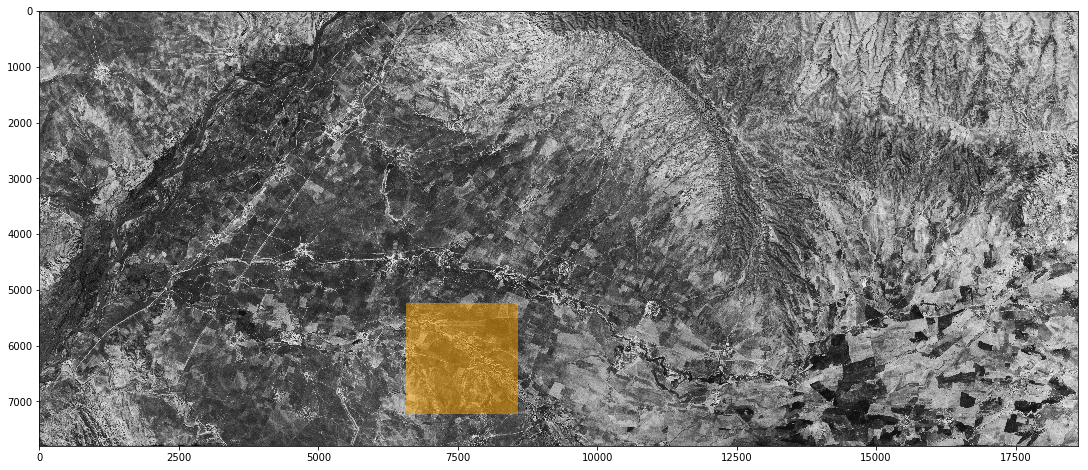

In [15]:
plt.figure(figsize=(24,8))
annotation_area = np.zeros_like(nda)
annotation_area[start[1]:end[1], start[0]:end[0]] = 255
annotation_area = np.ma.masked_where(annotation_area== 0, annotation_area)
plt.imshow(nda, cmap=plt.cm.gray)
plt.imshow(annotation_area, alpha=0.5,  cmap=cmap)

In [16]:
ccf = sitk.ConnectedComponentImageFilter()
ccf.SetFullyConnected(True)
ccf_labelmap = ccf.Execute(label)
stats_filter = sitk.LabelStatisticsImageFilter()
stats_filter.Execute(ccf_labelmap, ccf_labelmap)
labels = list(stats_filter.GetLabels())
labels.remove(0)
print(len(labels))

212


In [19]:
changeFilter = sitk.ChangeLabelImageFilter()
changeMap = sitk.DoubleDoubleMap()
for label_val in labels:
    changeMap[label_val] = int(np.random.randint(0,255,1)[0])
ccf_labelmap_random = changeFilter.Execute(ccf_labelmap, changeMap)

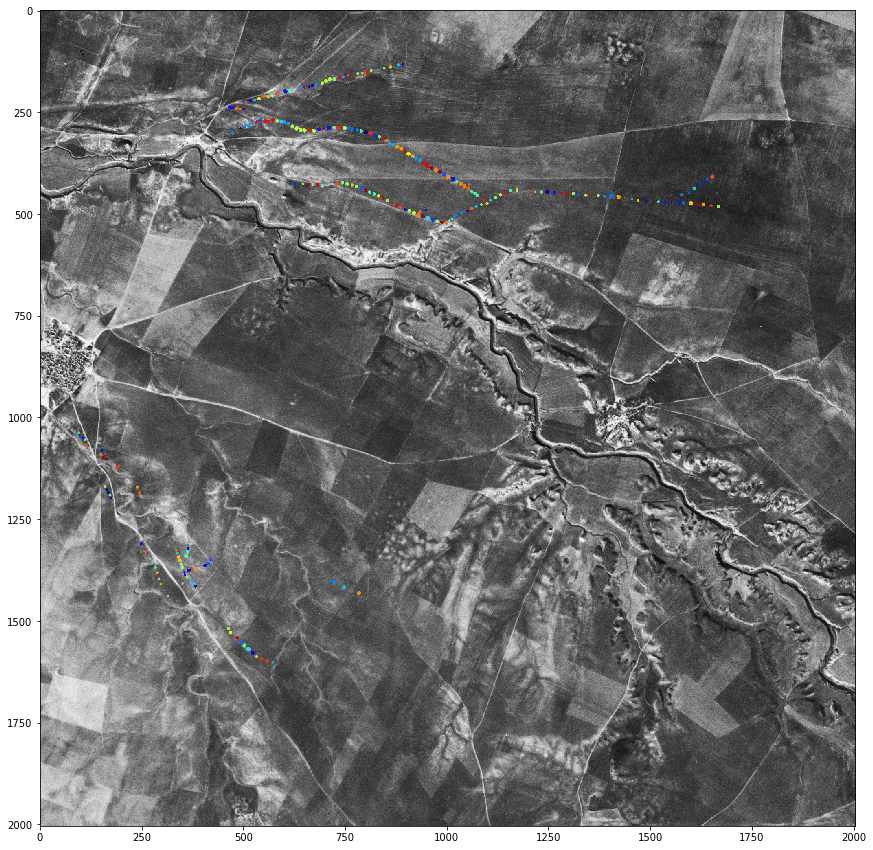

In [20]:
plt.figure(figsize=(15,15))
label_nda = sitk.GetArrayFromImage(ccf_labelmap_random).squeeze()
label_mask = np.ma.masked_where(label_nda== 0, label_nda)
plt.imshow(nda[start[1]:end[1], start[0]:end[0]], cmap=plt.cm.gray)
plt.imshow(label_mask[start[1]:end[1], start[0]:end[0]], alpha=0.9,cmap=plt.cm.jet)

In [21]:
d = []
pd.DataFrame(d)
for label_value in labels:
    bb = np.asarray(stats_filter.GetBoundingBox(label_value))
    d.append({'label': label_value, 'count': stats_filter.GetCount(label_value), 'x': int( bb[0] + (bb[1]-bb[0])/2), 
              'y': int(bb[2] + (bb[3]-bb[2])/2)}) 

In [22]:
df = pd.DataFrame(d)

In [23]:
len(df)

212

In [174]:

largest = df.sort_values('count', ascending=False).head(25)
smallest = df.sort_values('count', ascending=True).head(25)
largest

count  label     x     y
11      699     12  5060  5028
197     372    198  4244  5296
166     340    167  3814  5280
169     322    170  5460  5282
207     313    208  3891  5303
28      307     29  4425  5074
44      265     45  4120  5087
30      265     31  4378  5076
6       263      7  5163  5016
671     260    672  4349  6129
872     242    873  5112  6622
439     232    440  5283  5802
20      232     21  5094  5030
48      231     49  4673  5107
833     228    834  4940  6584
752     212    753  5307  6371
3       210      4  4992  5003
1049    209   1050  3960  6943
393     208    394  4667  5723
82      206     83  5728  5222
103     205    104  5719  5253
844     204    845  5088  6594
36      202     37  4553  5081
702     197    703  4418  6192
722     196    723  5758  6237

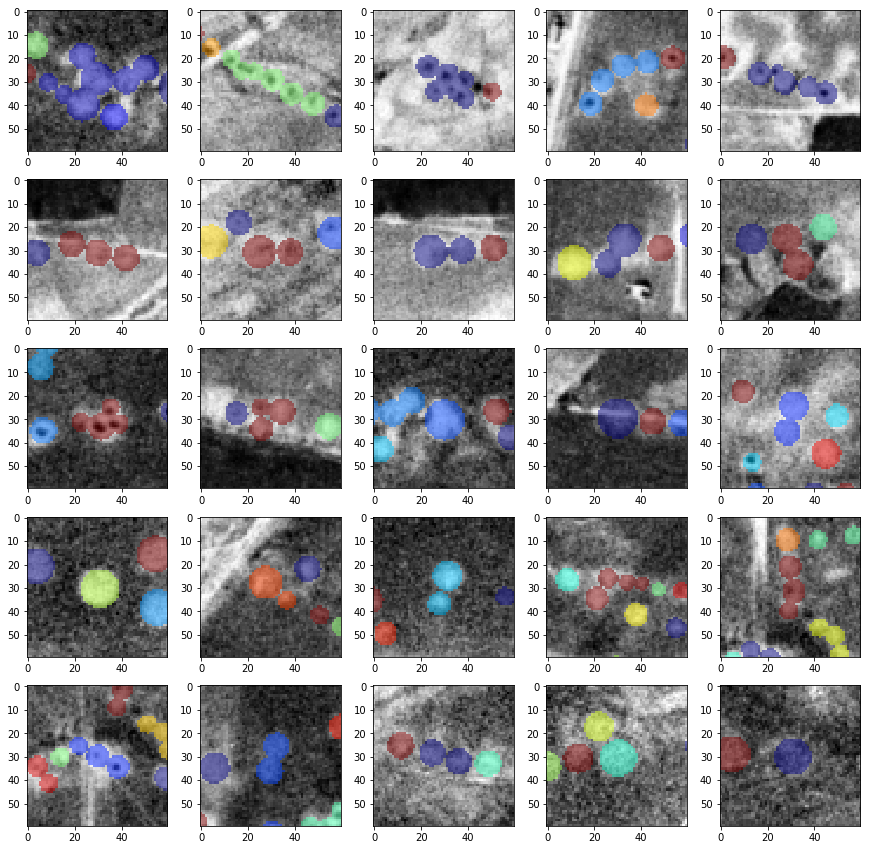

In [175]:
fig, axs = plt.subplots(5,5, figsize=(15, 15), facecolor='w', edgecolor='k')
pad = 30
axs = axs.ravel()
i = 0
for index, row in largest.iterrows():
    x = row['x']
    y = row['y']
    label_val = row['label']
    axs[i].imshow(nda[-pad+y:pad+y, -pad+x:pad+x], cmap=plt.cm.gray)
    axs[i].imshow(label_mask[-pad+y:pad+y, -pad+x:pad+x], alpha=0.5, cmap=plt.cm.jet)
    i +=1

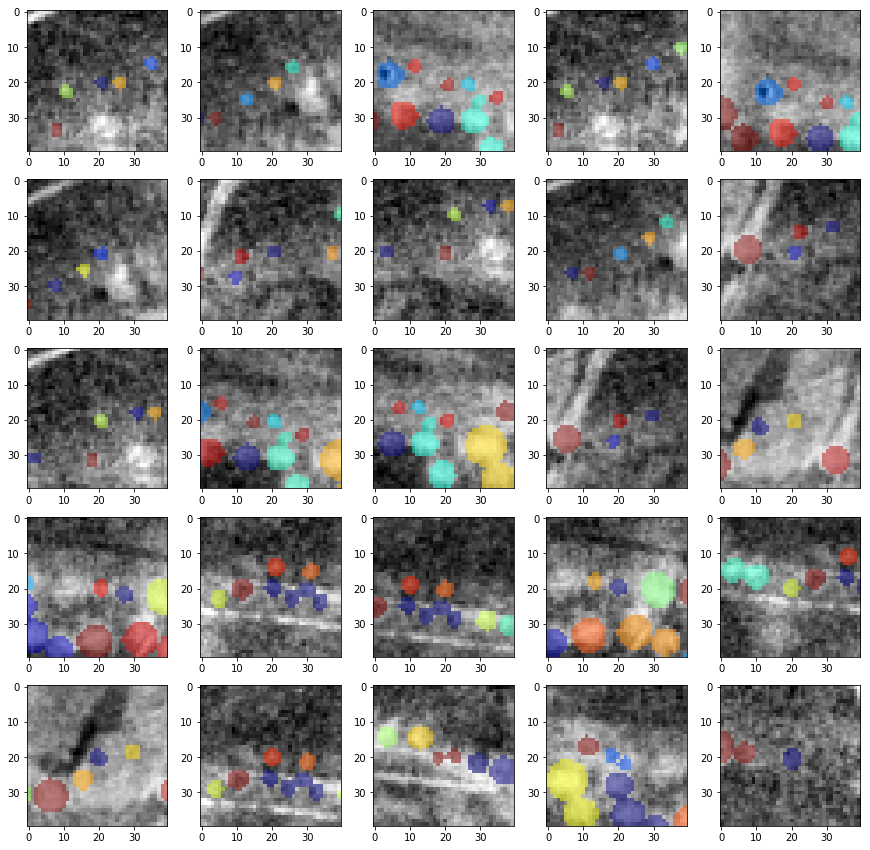

In [176]:
fig, axs = plt.subplots(5,5, figsize=(15, 15), facecolor='w', edgecolor='k')
pad = 20
axs = axs.ravel()
i = 0
for index, row in smallest.iterrows():
    x = row['x']
    y = row['y']
    label_val = row['label']
    axs[i].imshow(nda[-pad+y:pad+y, -pad+x:pad+x], cmap=plt.cm.gray)
    axs[i].imshow(label_mask[-pad+y:pad+y, -pad+x:pad+x], alpha=0.5, cmap=plt.cm.jet)
    i +=1

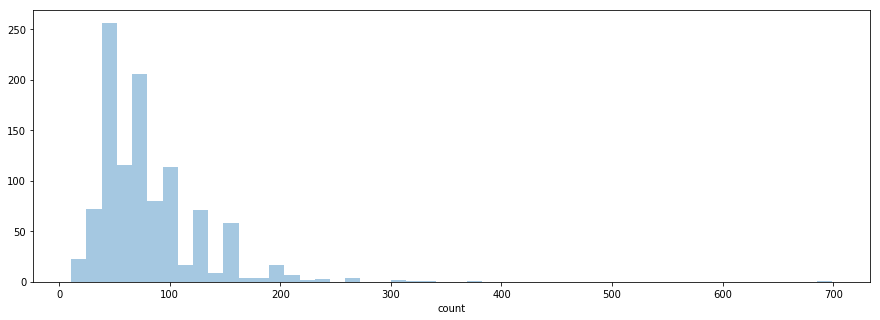

In [177]:
tmp_df = df[df.label != 618] # this is based on random ...
plt.figure(figsize=(15, 5))
sns.distplot(tmp_df['count'],  kde=False)

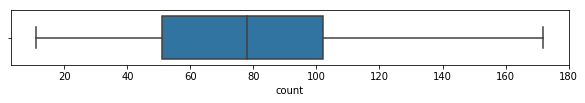

In [178]:
plt.figure(figsize=(10, 1))
sns.boxplot(df['count'],showfliers=False)

In [179]:
pred_path = os.path.join(train_folder, '2017_09_21_19_08_34', 'test_predictions', 'pilot_reconstructed.npy')

In [180]:
pred = np.load(pred_path)

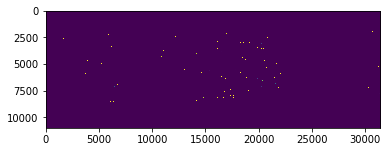

In [181]:
plt.imshow(pred)
plt.show()

In [37]:
pred_image =sitk.GetImageFromArray(pred) 
pred_image.CopyInformation(image)
sitk.WriteImage(pred_image , os.path.join(intermediate_folder, 'goh.nrrd'))